# 🏥 Predicting Hospital Readmission Risk: Exploratory Data Analysis (EDA)
## Student A – Data Engineer / Preprocessing Lead (Binger)
This notebook contains the final Exploratory Data Analysis (EDA) for the cleaned dataset, supporting the claims and figures presented in Section 3 (Dataset) of the final report.


## 1. Setup and Data Loading
This section imports necessary libraries, sets visualization styles, and loads the final cleaned dataset (`diabetes_cleaned.csv`).

### 1.1 Imports and Settings

In [237]:
# 1.1 Imports and Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from pathlib import Path 

# Suppress the specific Pandas FutureWarning related to column access/iteration
warnings.simplefilter(action='ignore', category=FutureWarning) 

# Set a professional plot style and high resolution for report quality
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150 # High resolution for export
pd.set_option("display.max_columns", 50)

# -----------------------------------------------------------
# Define Figure Output Path and create the directory
# Assumes the notebook is run from the project root or src/
# -----------------------------------------------------------
try:
    # Path to ../results/figures relative to the notebook
    FIG_DIR = Path("..") / "results" / "figures"
    FIG_DIR.mkdir(parents=True, exist_ok=True)  # create if it doesn't exist

    print(f"Figures will be saved to: {FIG_DIR.resolve()}")
except Exception as e:
    print(f"Warning: Could not create figure directory. Saving to local folder. Error: {e}")
    FIG_DIR = Path(".") # Fallback to current directory

Figures will be saved to: /Users/bingeryu/PycharmProjects/hospital-readmission-prediction/results/figures


### 1.2 Load Cleaned Data 


In [238]:
try:
    # NOTE: 'diabetes_cleaned.csv' is the output of the data_preprocessing.py script.
    df = pd.read_csv("../data/processed/diabetes_cleaned.csv")
    print(f"Cleaned data loaded successfully. Final Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'diabetes_cleaned.csv' not found. Please check the file path.")

Cleaned data loaded successfully. Final Shape: (101763, 46)


Review the Dataset

### 1.3 Define Feature Categories for Plotting (Used in 3.5)

In [239]:
# Define categories based on the original structure and final feature set for Figure 3.5
FEATURE_CATEGORIES = {
    'Demographics': ['race', 'gender', 'age'],
    'Admission/Discharge': ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'],
    'Hospital Stay': ['time_in_hospital'],
    'Utilization Metrics': ['number_outpatient', 'number_emergency', 'number_inpatient', 'service_utilization'],
    'Lab & Procedures': ['num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses'],
    'Medications': ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
                    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
                    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'],
    'Diagnosis Codes': ['diag_1', 'diag_2', 'diag_3'],
    'Target': ['readmitted_binary']
}

## 2. Descriptive Statistics
This section confirms the dataset's final state and key metrics, such as the overall readmission rate, which establishes the class imbalance.

In [240]:
# 2.1 Display Target Statistics and Class Imbalance
total_records = len(df)
readmitted_count = df['readmitted_binary'].sum()
readmission_rate = (readmitted_count / total_records) * 100

print(f"Total Records: {total_records}")
print(f"Readmitted (<30 days) Count: {readmitted_count}")
print(f"Readmission Rate (Class Imbalance): {readmission_rate:.2f}%")


Total Records: 101763
Readmitted (<30 days) Count: 11357
Readmission Rate (Class Imbalance): 11.16%


In [241]:

# 2.2 Summary Statistics for Key Numeric Features
key_features = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 'number_inpatient', 'service_utilization']
print("\nDescriptive Statistics for Key Predictors:")
print(df[key_features].describe().T)


Descriptive Statistics for Key Predictors:
                        count       mean        std  min   25%   50%   75%    max
time_in_hospital     101763.0   4.396018   2.985092  1.0   2.0   4.0   6.0   14.0
num_lab_procedures   101763.0  43.095909  19.674220  1.0  31.0  44.0  57.0  132.0
num_medications      101763.0  16.021835   8.127589  1.0  10.0  15.0  20.0   81.0
number_inpatient     101763.0   0.635585   1.262877  0.0   0.0   0.0   1.0   21.0
service_utilization  101763.0   1.202795   2.291805  0.0   0.0   0.0   2.0   80.0


Features `max_glu_serum` and `A1Cresult` were dropped due to excessive missingness (>80%).
Minor missing values in `race` were imputed with the most frequent category, while missing diagnosis codes were replaced with “Unknown” to retain encounters.

## 3. Exploratory Visualizations (Figures for Final Report)

### 3.1 Figure 3.1: Distribution of Key Numeric Variables

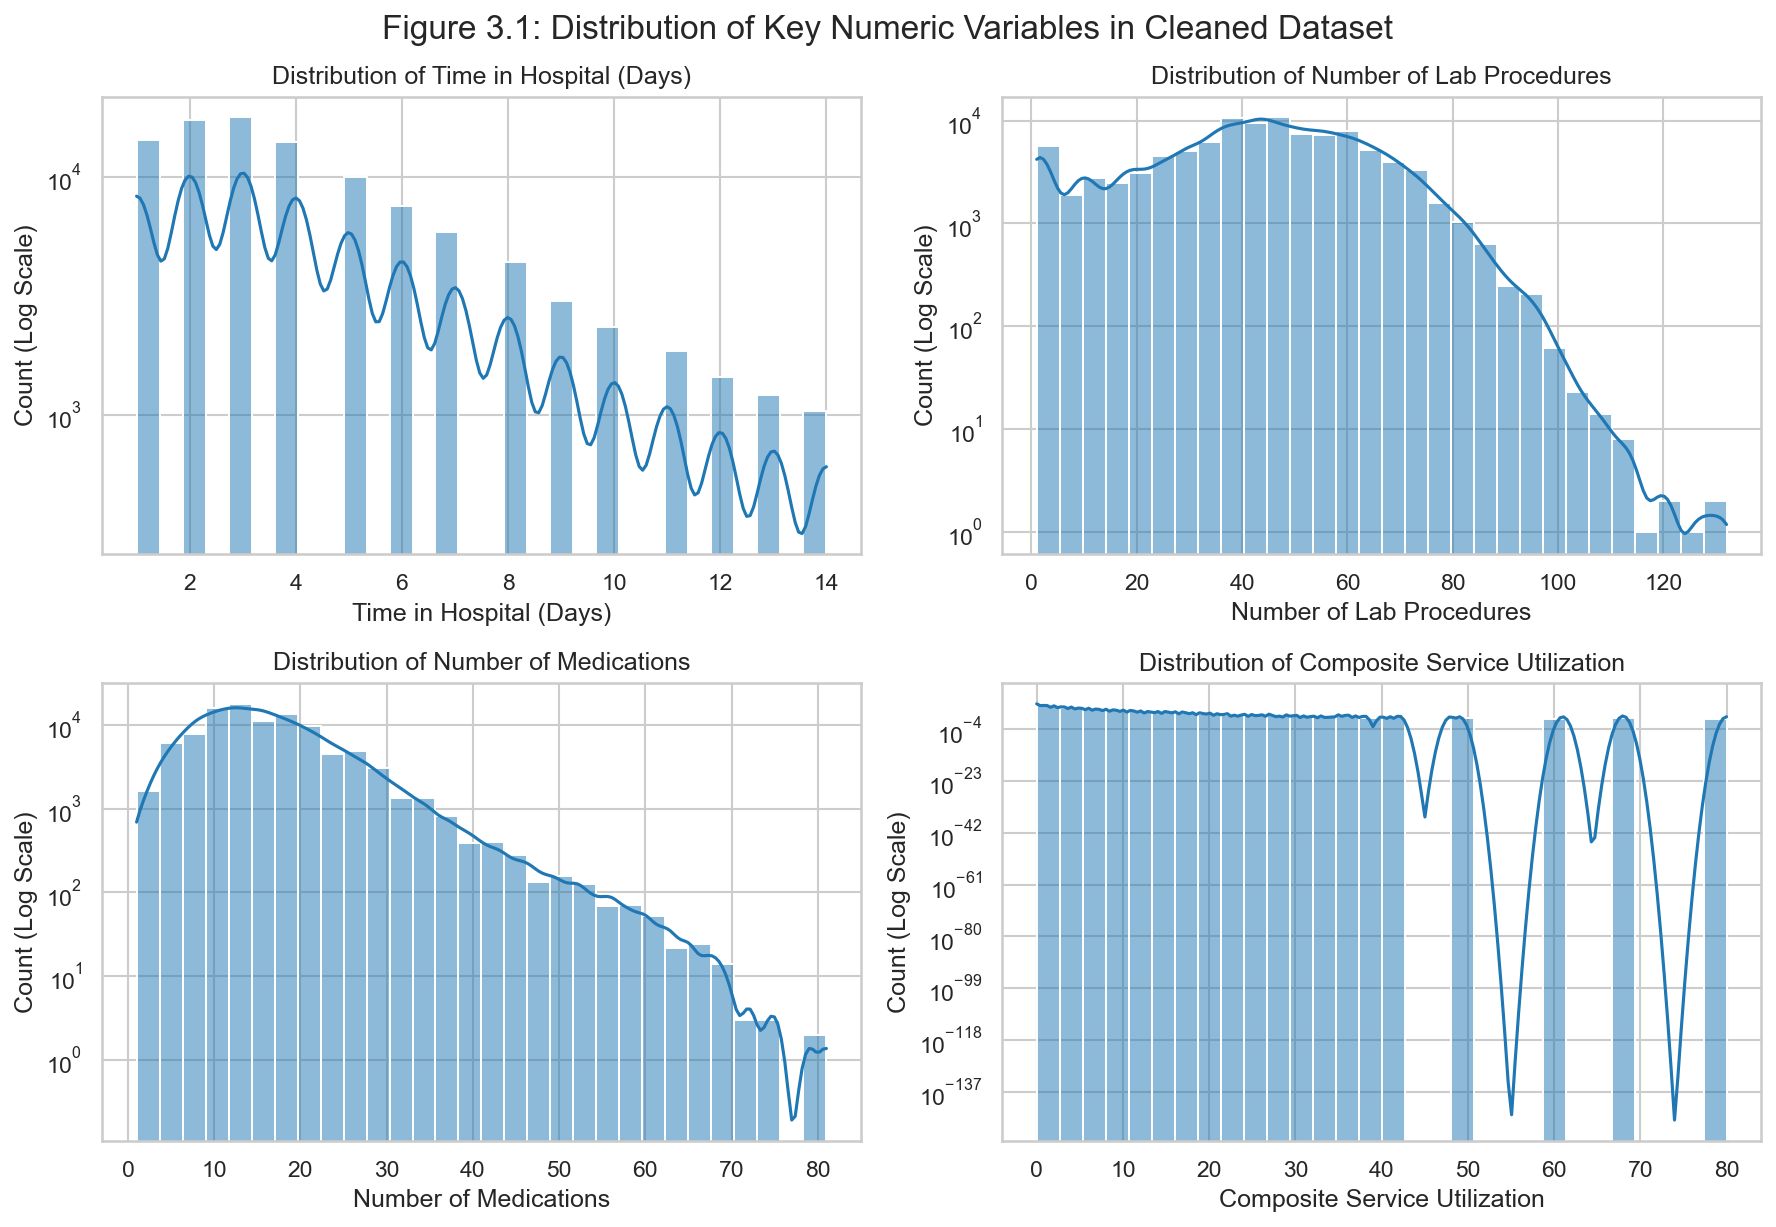

In [242]:
# 3.1 Figure 3.1: Distribution of Key Numeric Variables
key_numerics = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 'service_utilization']
titles = [
    'Time in Hospital (Days)',
    'Number of Lab Procedures',
    'Number of Medications',
    'Composite Service Utilization'
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(key_numerics):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color='#1f77b4')
    axes[i].set_title(f'Distribution of {titles[i]}', fontsize=12)
    axes[i].set_xlabel(titles[i])
    axes[i].set_ylabel('Count (Log Scale)')
    axes[i].set_yscale('log')

plt.tight_layout()
plt.suptitle("Figure 3.1: Distribution of Key Numeric Variables in Cleaned Dataset", y=1.02, fontsize=16)
plt.savefig(FIG_DIR / 'figure_3_1_distributions.png')
plt.show()

### 3.2 Figure 3.2: Readmission Rate by Hospital Stay Duration

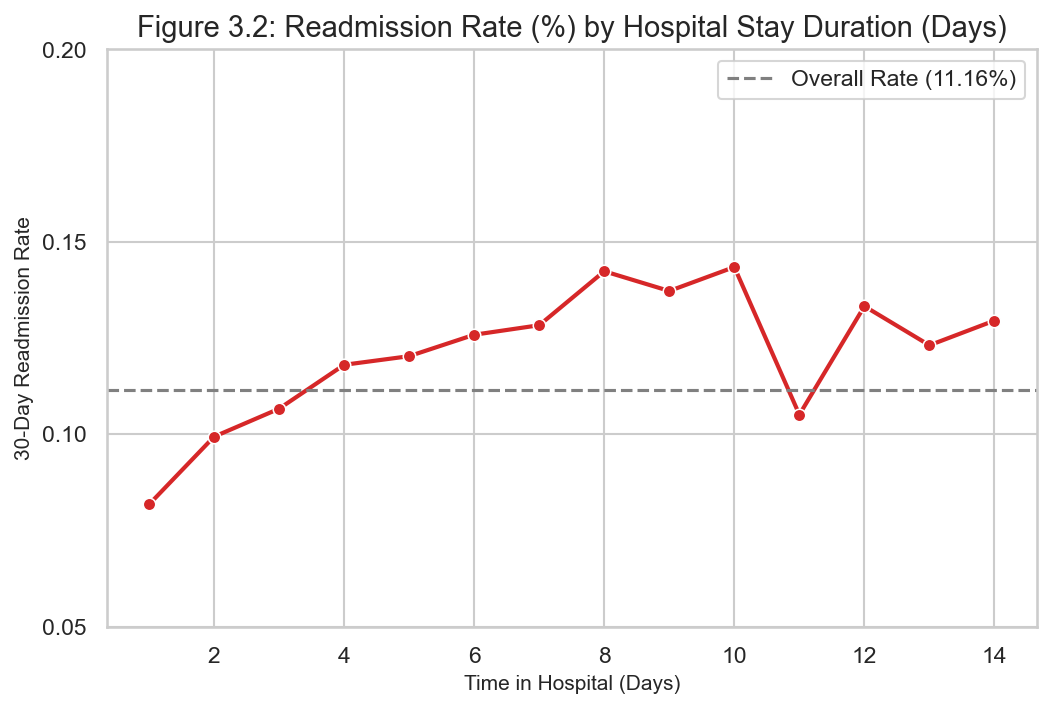

In [243]:
# 3.2 Figure 3.2: Readmission Rate by Hospital Stay Duration
readmission_rate_by_stay = df.groupby('time_in_hospital')['readmitted_binary'].mean().reset_index()
overall_rate = df['readmitted_binary'].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=readmission_rate_by_stay,
    x='time_in_hospital',
    y='readmitted_binary',
    marker='o',
    color='#d62728',
    linewidth=2
)

# Add a horizontal line to indicate the overall mean rate
plt.axhline(overall_rate, color='grey', linestyle='--', label=f'Overall Rate ({overall_rate*100:.2f}%)')

plt.title("Figure 3.2: Readmission Rate (%) by Hospital Stay Duration (Days)", fontsize=14)
plt.xlabel("Time in Hospital (Days)", fontsize=10)
plt.ylabel("30-Day Readmission Rate", fontsize=10)
plt.yticks([0.05, 0.10, 0.15, 0.20])
plt.ylim(0.05, 0.20)
plt.legend()
plt.savefig(FIG_DIR / 'figure_3_2_readmission_by_stay.png')
plt.show()

### 3.3 Figure 3.3: Average Clinical Metrics by Patient Age Group

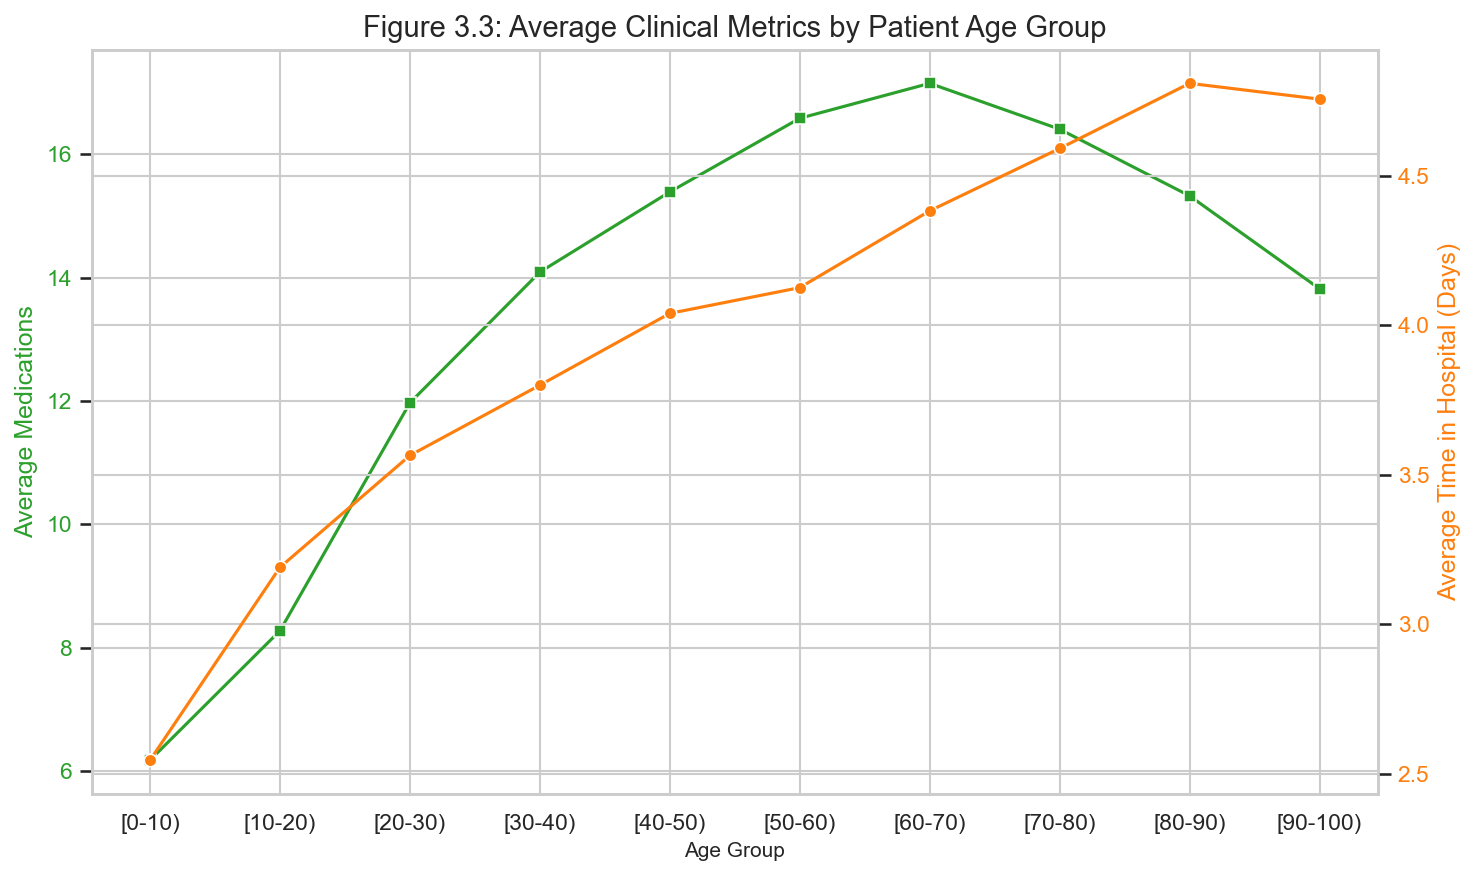

In [244]:
# 3.3 Figure 3.3: Average Metrics by Age Group
age_trends = df.groupby('age').agg(
    avg_medications=('num_medications', 'mean'),
    avg_time_in_hospital=('time_in_hospital', 'mean')
).reset_index()

# Explicitly define the correct chronological order for the age categories
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', 
             '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
             
age_trends['age'] = pd.Categorical(age_trends['age'], categories=age_order, ordered=True)
age_trends = age_trends.sort_values('age')


fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = '#2ca02c' # Green for medications
sns.lineplot(data=age_trends, x='age', y='avg_medications', ax=ax1, marker='s', color=color1)
ax1.set_ylabel('Average Medications', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second axis for Time in Hospital
ax2 = ax1.twinx()
color2 = '#ff7f0e' # Orange for time in hospital
sns.lineplot(data=age_trends, x='age', y='avg_time_in_hospital', ax=ax2, marker='o', color=color2)
ax2.set_ylabel('Average Time in Hospital (Days)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_title("Figure 3.3: Average Clinical Metrics by Patient Age Group", fontsize=14)
ax1.set_xlabel("Age Group", fontsize=10)
plt.tight_layout()
plt.savefig(FIG_DIR / 'figure_3_3_age_trends.png')
plt.show()


### 3.4 Figure 3.4: Top 10 Feature Correlations

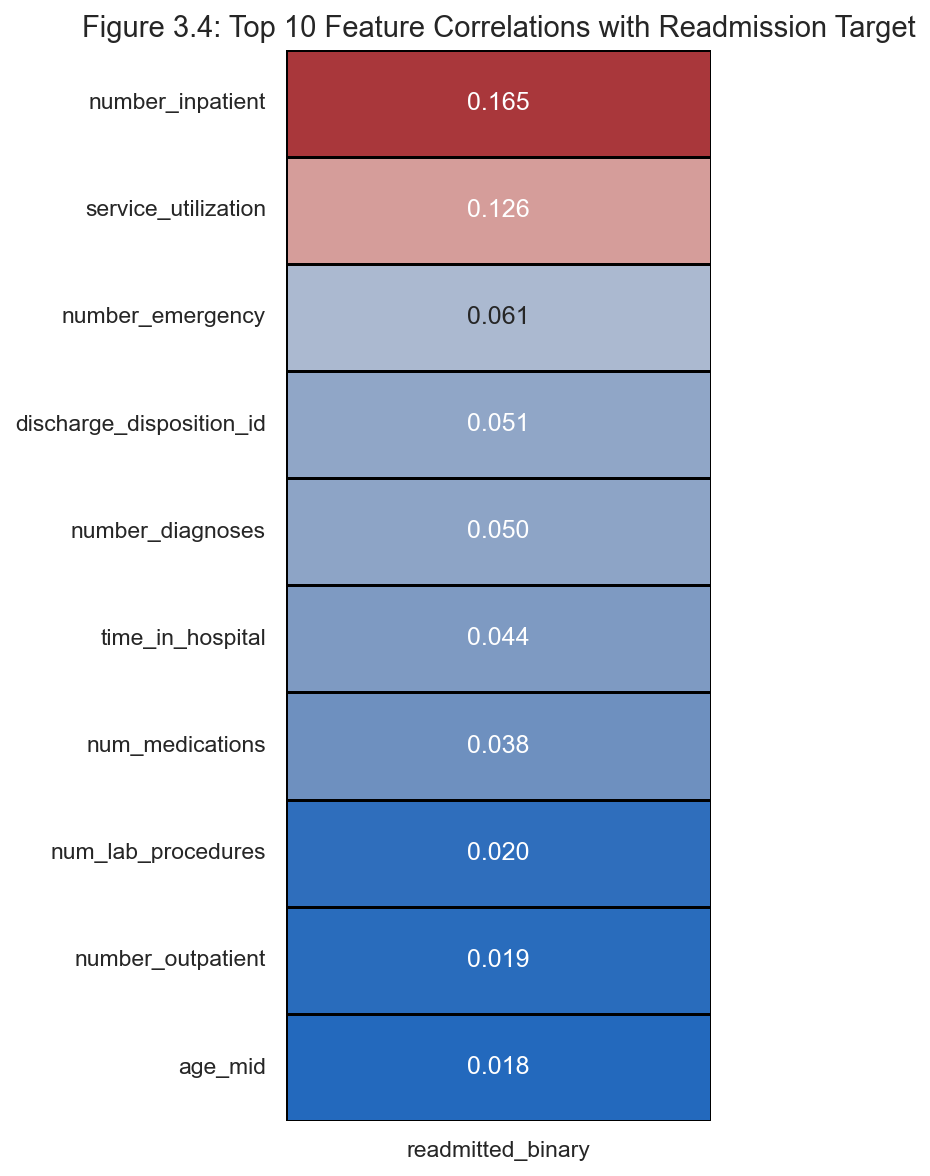

In [245]:
# 3.4 Figure 3.4: Top 10 Feature Correlations
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_df = df[numeric_cols].corr()

# 1. Focus only on correlations with the target variable, 'readmitted_binary'
target_corr = corr_df['readmitted_binary'].sort_values(ascending=False).drop('readmitted_binary')

# 2. Select the top 10 absolute correlations for better visualization in the report
top_features = target_corr.abs().sort_values(ascending=False).index[:10].tolist()
target_corr_top = target_corr.loc[top_features]


plt.figure(figsize=(5, 8))
sns.heatmap(
    target_corr_top.to_frame(),
    annot=True,
    fmt=".3f",
    cmap='vlag',
    cbar=False,
    linewidths=0.5,
    linecolor='black'
)
plt.title("Figure 3.4: Top 10 Feature Correlations with Readmission Target", fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_DIR / 'figure_3_4_correlation_heatmap.png')
plt.show()

### 3.5 Figure 3.5: Feature Categories Count

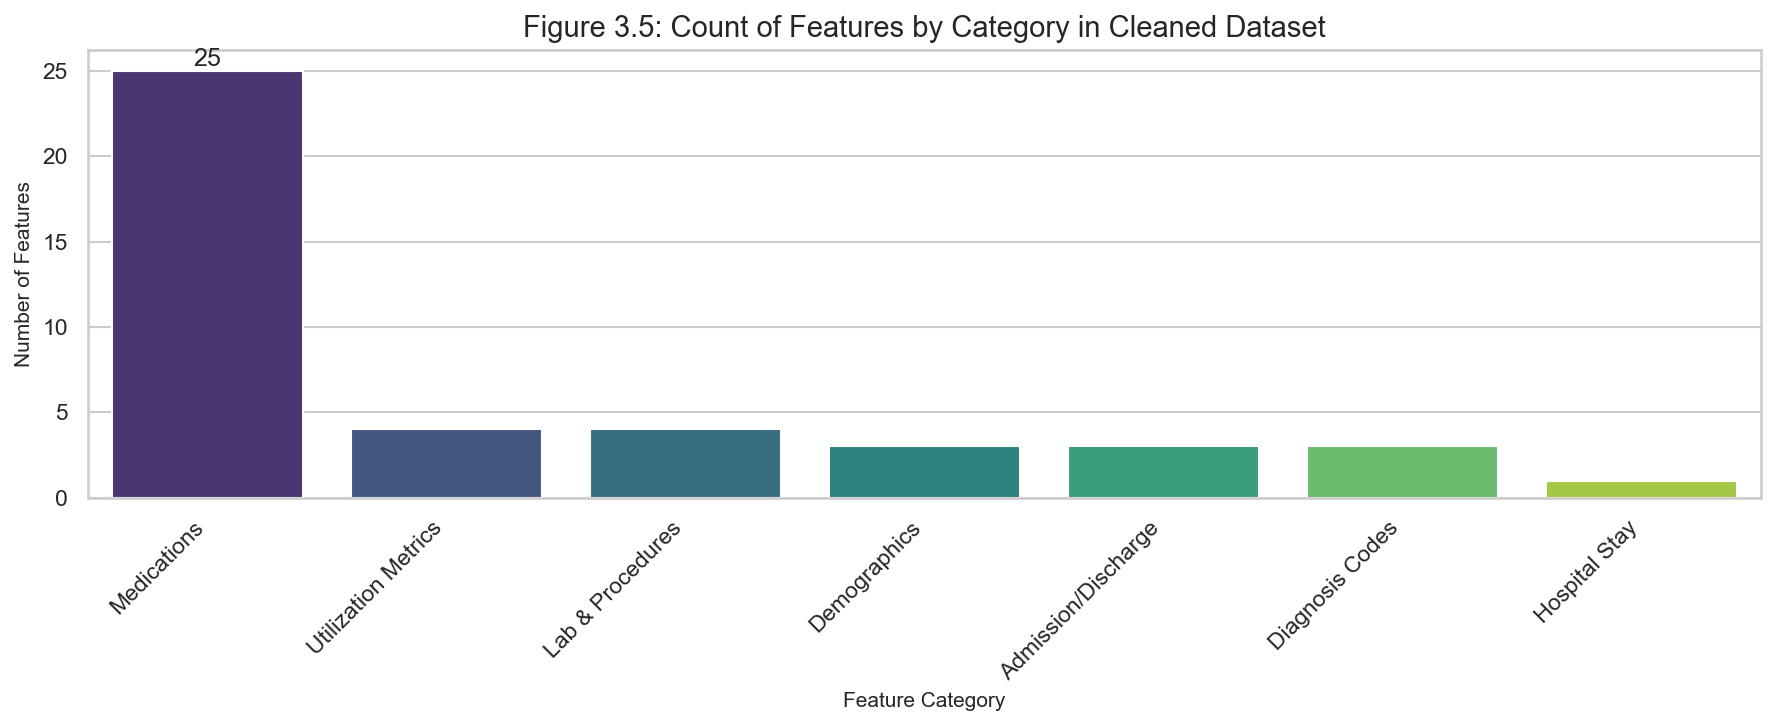

In [246]:
# 3.5 Figure 3.5: Feature Categories Count
# Use the dictionary defined in the setup section to count features per category
category_counts = {k: len(v) for k, v in FEATURE_CATEGORIES.items()}
category_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count']).sort_values('Count', ascending=False)
category_df = category_df[category_df['Category'] != 'Target'] # Exclude target for counting features

plt.figure(figsize=(12, 5))
ax = sns.barplot(x='Category', y='Count', data=category_df, palette="viridis")
plt.title("Figure 3.5: Count of Features by Category in Cleaned Dataset", fontsize=14)
plt.xlabel("Feature Category", fontsize=10)
plt.ylabel("Number of Features", fontsize=10)
plt.xticks(rotation=45, ha='right')
ax.bar_label(ax.containers[0]) # Add count labels to bars
plt.tight_layout()
plt.savefig(FIG_DIR / 'figure_3_5_feature_counts.png')
plt.show()

## 4. Final Preprocessing for Modeling (Handoff)
This section documents the final transformation steps required before the data is split and fed into the classification models.

In [247]:
# 4.1 Categorical Feature Selection
# Drop redundant columns and select only those needed for OHE
# We use select_dtypes to robustly identify object columns, which fixes the warning.
columns_to_drop_pre_modeling = ['age', 'readmitted']
all_object_cols = df.select_dtypes(include='object').columns.tolist()

features_for_ohe = [col for col in all_object_cols if col not in columns_to_drop_pre_modeling]

print("Features requiring One-Hot Encoding (OHE):")
print(features_for_ohe)

# 4.2 Data Splitting Strategy (Conceptual)
print("\n[Handoff Documentation for Modeling Lead]")
print("Data is now ready for the following sequential steps:")
print("1. Separate features (X) from the binary target (y = 'readmitted_binary').")
print("2. Split data into Train/Validation/Test sets (e.g., 70/10/20).")
print("3. Apply One-Hot Encoding (OHE) ONLY on the training features (X_train) and then transform X_val and X_test.")
print("4. Apply scaling (e.g., StandardScaler) on numeric features derived from the training set.")
print("Data is ready for Savina (Modeling Lead) to execute the final split and training pipeline.")

Features requiring One-Hot Encoding (OHE):
['race', 'gender', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

[Handoff Documentation for Modeling Lead]
Data is now ready for the following sequential steps:
1. Separate features (X) from the binary target (y = 'readmitted_binary').
2. Split data into Train/Validation/Test sets (e.g., 70/10/20).
3. Apply One-Hot Encoding (OHE) ONLY on the training features (X_train) and then transform X_val and X_test.
4. Apply scaling (e.g., StandardScaler) on numeric features derived from the training set.
Data is ready for Savina (Modeling Lead) to execute the final 